In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from statsmodels.tsa.tsatools import detrend
from functools import partial 
import xarray as xr
from thesis_toolbox.plot.tools import latex_plot
from thesis_toolbox.utils import get_locations_CLP
import matplotlib.cm as cm
import matplotlib
# latex_plot()
%matplotlib inline

In [2]:
def plot_correlations(df, figsize=(27,23)):
    corrs = df.corr()
    p_values = df.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(df.columns)) 
    mask = np.triu(np.ones_like(corrs.values, dtype=bool))
    corrs_triu = corrs.where((mask==False)) 
    significant_corrs = corrs_triu.round(2).where((p_values <=0.05), other='')

    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    ax.set_aspect('equal')


    sns.heatmap(corrs.values, mask=mask,
                xticklabels=corrs.columns.values,annot=significant_corrs,
                yticklabels=corrs.columns.values, ax=ax, cmap='coolwarm',fmt='',annot_kws={'fontsize':8, 'color':'black'}, vmin=-1,vmax=1)

In [3]:
if 'snakemake' in globals():
    to_file = True
    path='./'
else:
    path = '../../'
    to_file= False

In [4]:
    df = pd.read_csv(path+'results/timeseries_table.csv',index_col=0)

df = df.drop(['NAO station MAM', 'NAO station DJF', 'Emissions total'], axis=1)
# df['Emission taklamakan/Emissions NW'] = (df['Emissions taklamakan']/df['Emissions taklamakan'].mean())-(df['Emissions north_west']/df['Emissions north_west'].mean())


detrend_func = partial(detrend, axis=1)
detrended=df.apply(detrend_func,raw=True)

## Correlation matrix without detrending

<AxesSubplot:>

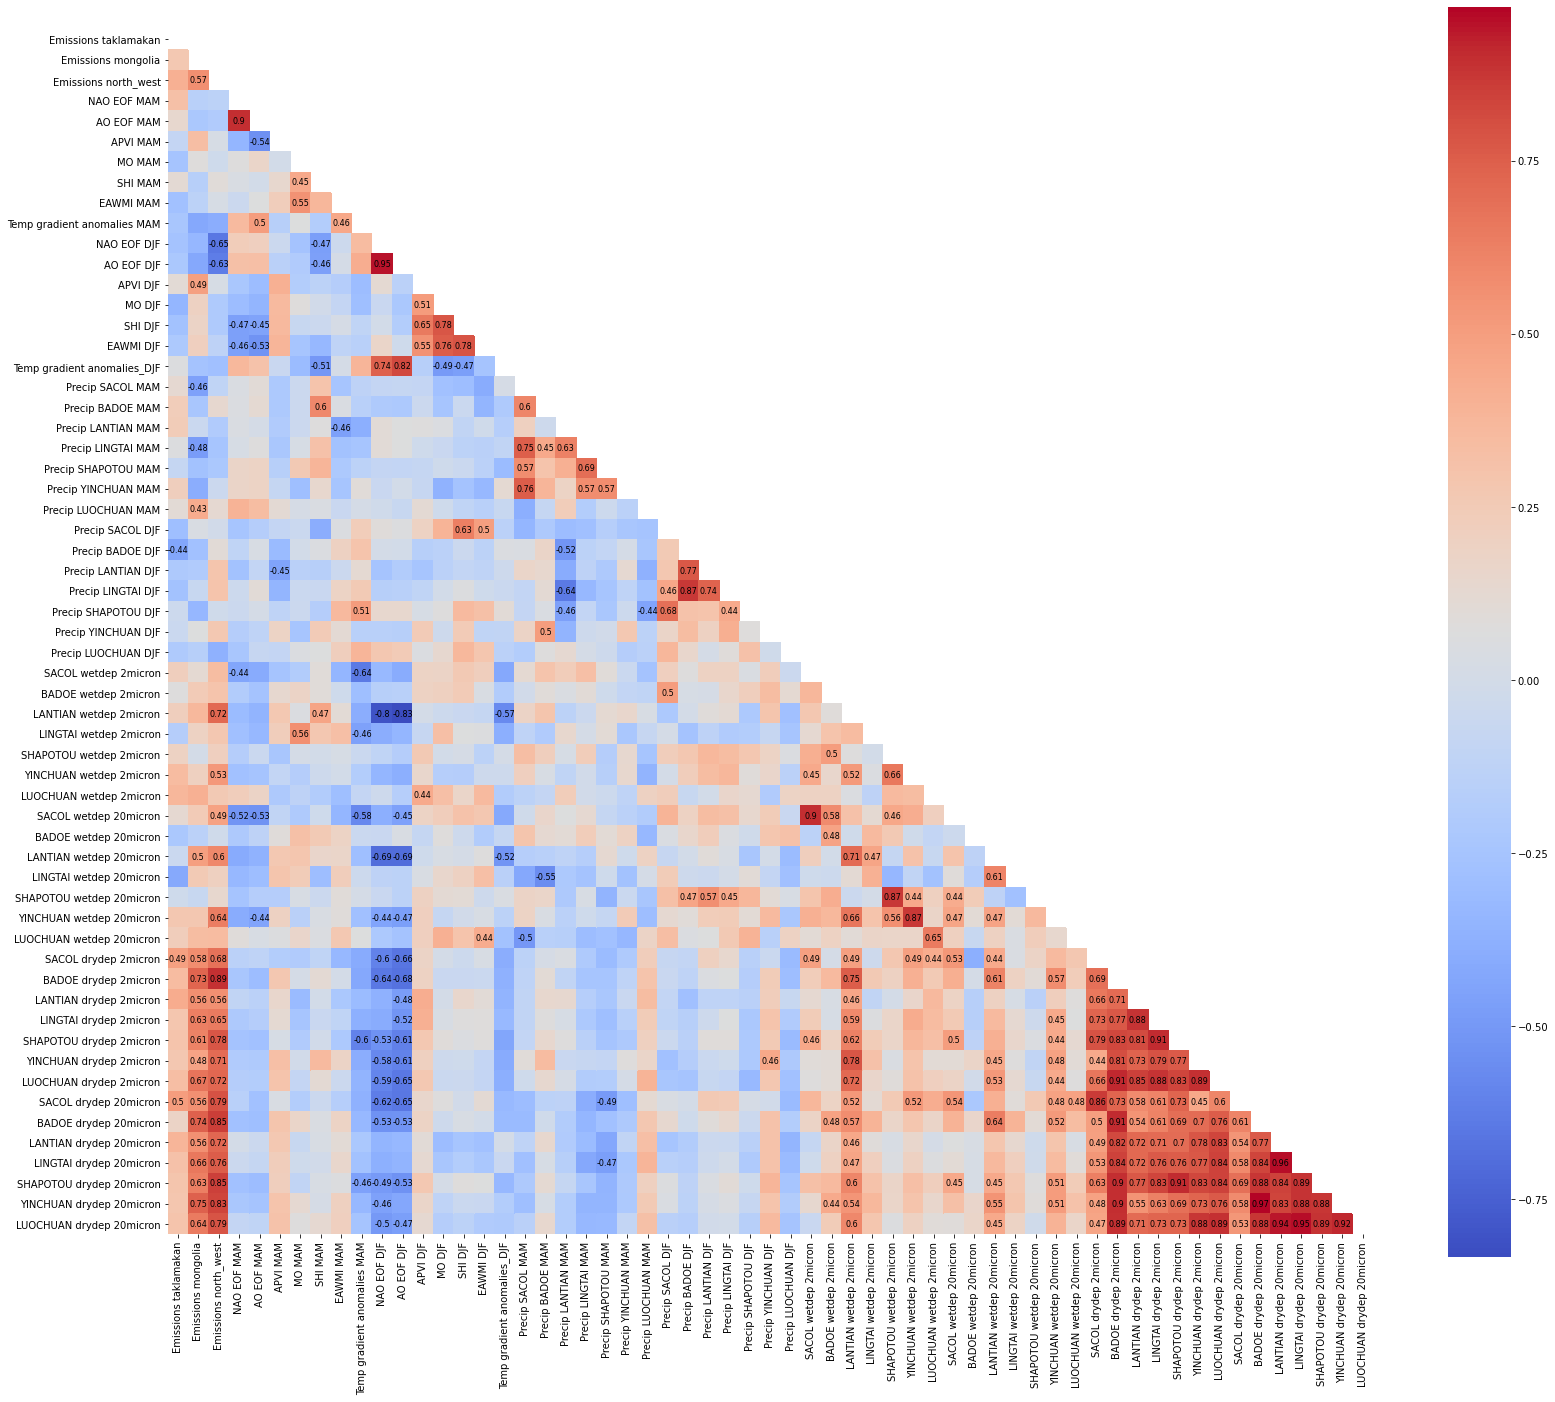

In [5]:
corrs = df.corr()
p_values = df.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(df.columns)) 
mask = np.triu(np.ones_like(corrs.values, dtype=bool))
corrs_triu = corrs.where((mask==False)) 
significant_corrs = corrs_triu.round(2).where((p_values <=0.05), other='')

fig = plt.figure(figsize=(27,23))
ax = plt.axes()
ax.set_aspect('equal')


sns.heatmap(corrs.values, mask=mask,
            xticklabels=corrs.columns.values,annot=significant_corrs,
            yticklabels=corrs.columns.values, ax=ax, cmap='coolwarm',fmt='',annot_kws={'fontsize':8, 'color':'black'})
# plt.savefig('../figs/correlations.png',bbox_inches='tight', dpi=144)
# sns.heatmap()

## Detrended results

In [6]:
locs = get_locations_CLP().index
detrended = detrended.drop(labels=[f'Precip {loc} MAM' for loc in locs],axis=1)
detrended = detrended.drop(labels=[f'Precip {loc} DJF' for loc in locs],axis=1)

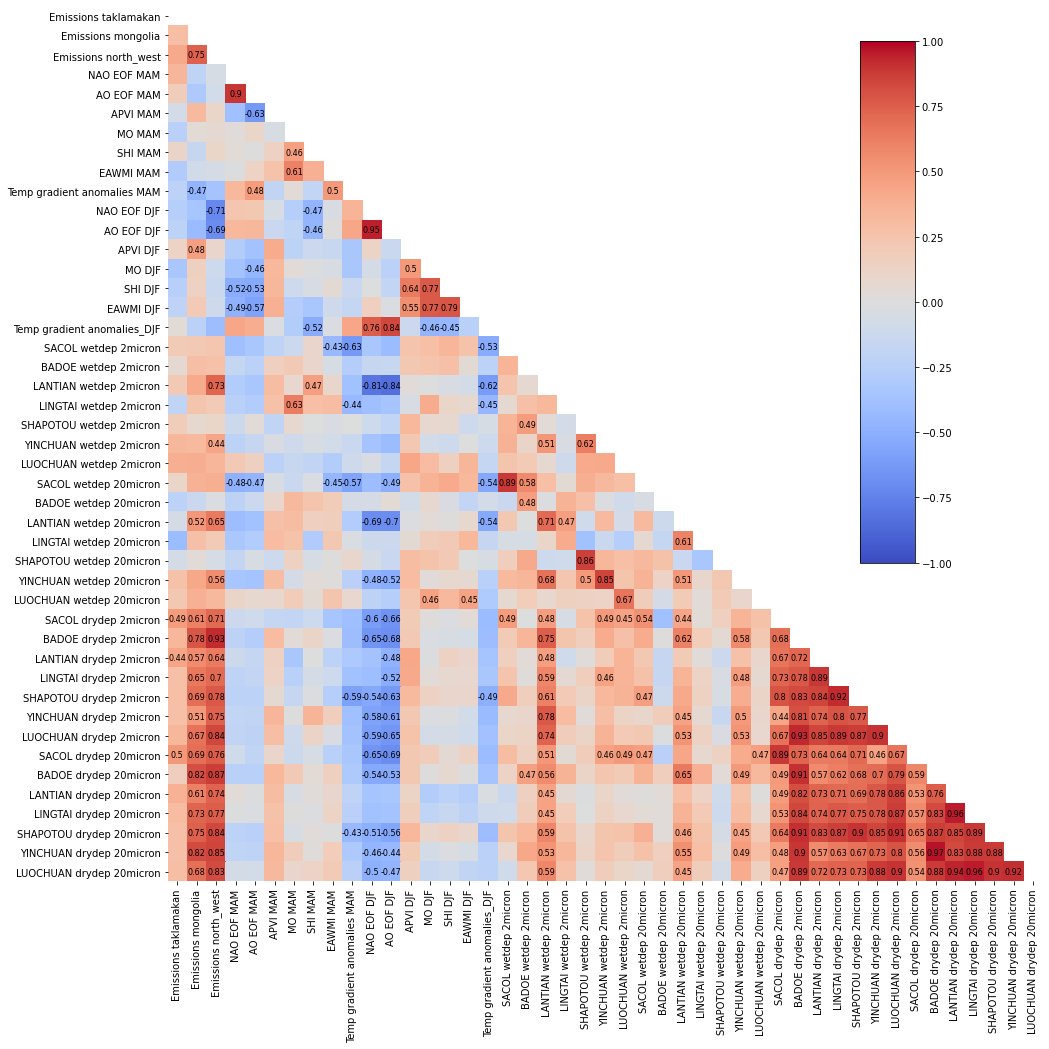

In [7]:

corrs = detrended.corr()
p_values = detrended.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(detrended.columns)) 
mask = np.triu(np.ones_like(corrs.values, dtype=bool))
corrs_triu = corrs.where((mask==False)) 
significant_corrs = corrs_triu.round(2).where((p_values <=0.05), other='')

fig = plt.figure(figsize=(27*.7,23*.7))
ax = plt.axes()
ax.set_aspect('equal')


sns.heatmap(corrs.values, mask=mask,
            xticklabels=corrs.columns.values,annot=significant_corrs,
            yticklabels=corrs.columns.values, ax=ax, cmap='coolwarm',fmt='',annot_kws={'fontsize':8, 'color':'black'}, 
            vmin=-1, vmax=1,cbar=False)
cax=fig.add_axes([0.7,0.4,0.04,0.45])
fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-1, vmax=1),cmap='coolwarm'),cax=cax)
if to_file:
    plt.savefig(snakemake.output.outpath,bbox_inches='tight')
# sns.heatmap()

Strong correlation between SH and MO and EAWMI suggest that both idicies are suitable for capturing the intensitity of the winter monsoon. The AO directly influences the surface temperature rather than the siberian high. Negative AO in winter does correspond to strenghtend SHI in spring. AO spring is positively correlated with temperature gradient in spring, which means weaker temperature gradient positive AO springs.The siberian High seems to be excluded from the AO influcence on dust depostion most of the sites except for Lantian and Lingtai, which show postive correlation between SHI and dust deposition.   

## Source contribution Taklamakan

In [8]:
from thesis_toolbox.utils import get_locations_CLP
from snakemake.io import expand
 



In [9]:
locs =get_locations_CLP().index

In [13]:
paths = expand(path+'results/model_results/{kind}/{kind}.{location}.{psize}.MAM.1999-2019.nc', 
      kind=['total_deposition'], psize=['20micron','2micron'],location=locs)

In [14]:
def get_source_contrib_taklamakan(path0,kind, locs=None, lon0=75, lon1=90,lat0=36,lat1=42):
    if locs == None:
        locs =get_locations_CLP().index
    paths = expand(path0+'{kind}/{kind}.{location}.{psize}.MAM.1999-2019.nc', 
      kind=kind, psize=['20micron','2micron'],location=locs)

    df = pd.DataFrame(np.zeros((len(xr.open_dataset(paths[0]).year),len(paths))), index=xr.open_dataset(paths[0]).year)

    for i,path in enumerate(paths):
    #     print(path)
        loc_name = path.split('/')[-1].split('.')[1]
        psize = path.split('/')[-1].split('.')[2]
        temp_ds = xr.open_dataset(path)
    #     print(temp_ds[temp_ds.varName].sel(lon=slice(lon0,lon1),lat=slice(lat1,lat0)))
        df.iloc[:,i] = temp_ds[temp_ds.varName].sel(lon=slice(lon0,lon1),lat=slice(lat0,lat1)).sum(dim=['lon','lat']).values
        df = df.rename(columns={i:f'{loc_name} {psize} {temp_ds.varName}'})
    return df

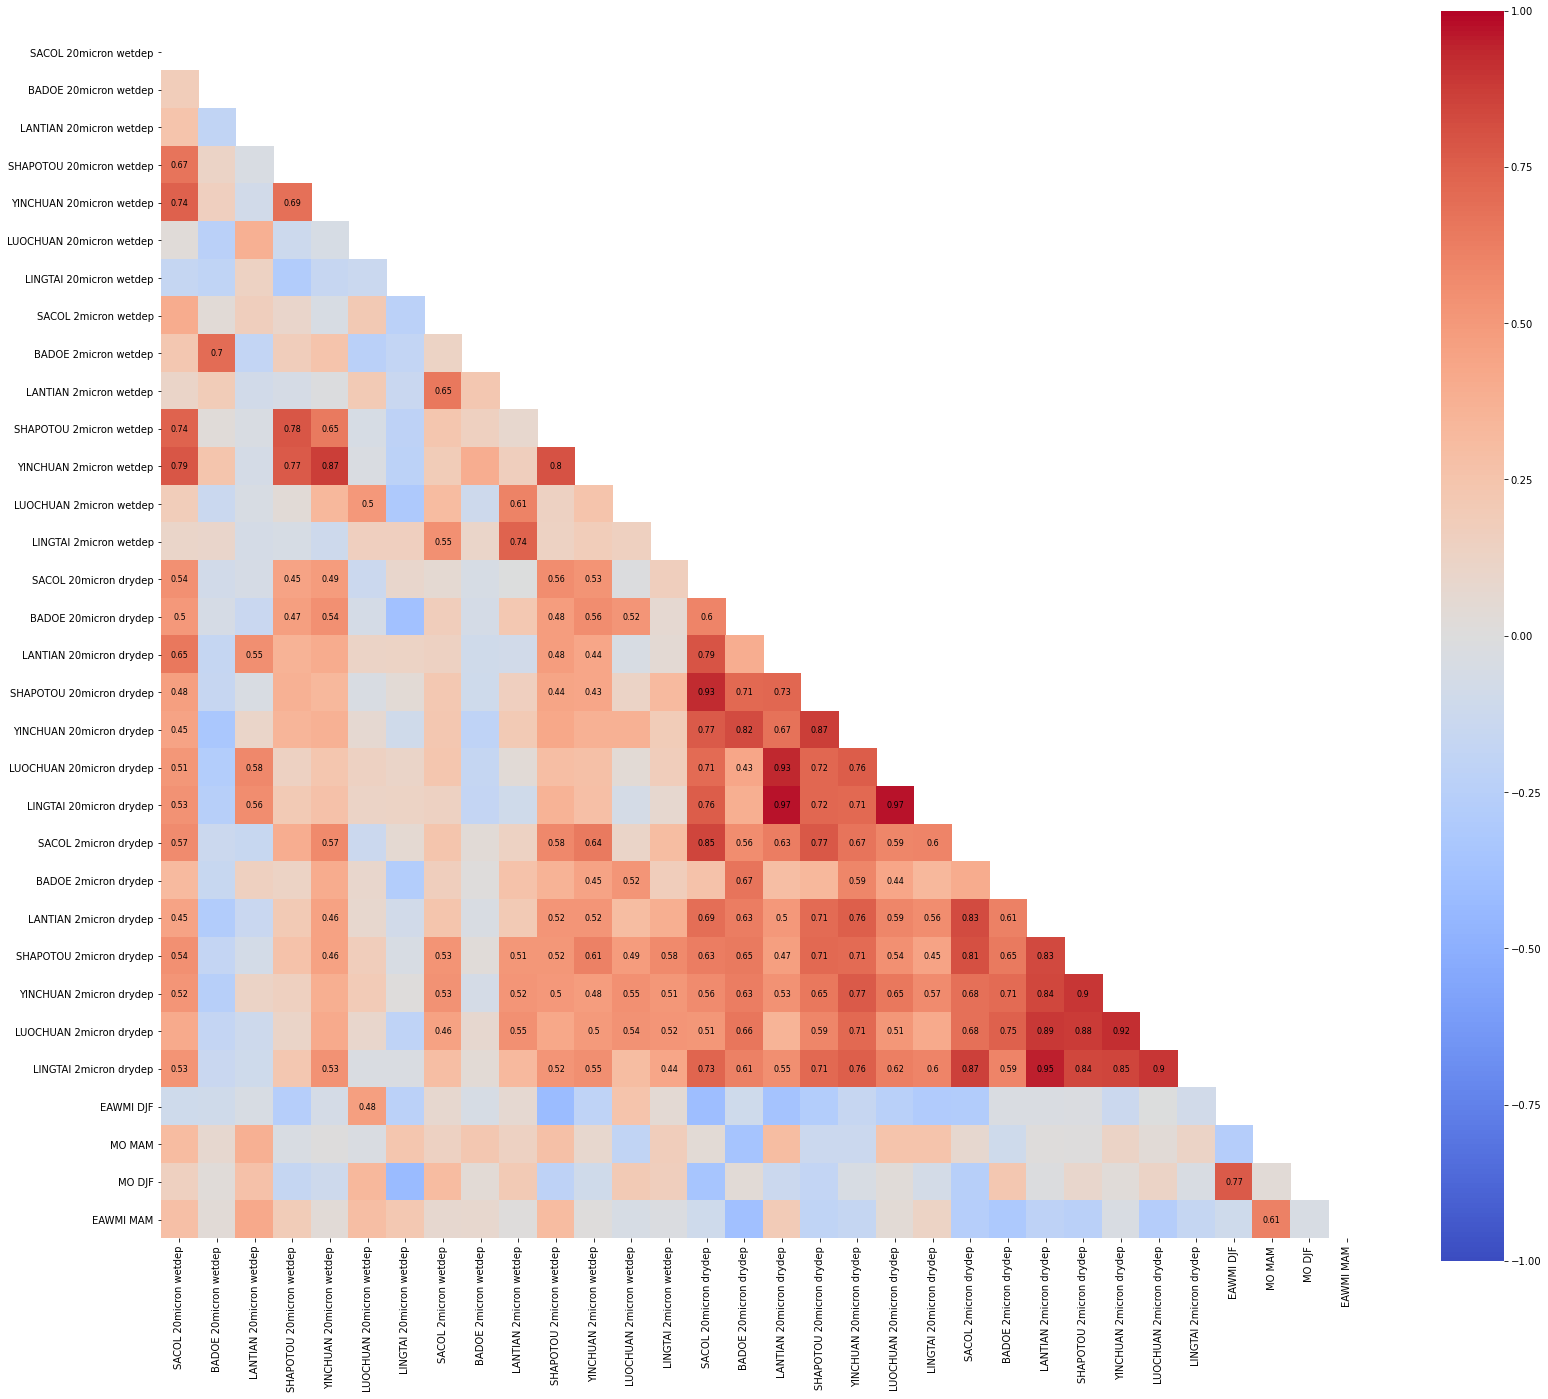

In [16]:
source_contrib_taklamakan = get_source_contrib_taklamakan(path+'results/model_results/', ['wetdep','drydep'])
plot_correlations(source_contrib_taklamakan.join(df[['EAWMI DJF','MO MAM','MO DJF','EAWMI MAM']]).apply(detrend_func,raw=True))

In [17]:
source_contrib_nw_clp = get_source_contrib_taklamakan(path+'results/model_results/', ['wetdep','drydep'],
                                                     lon0=100, lon1=110,lat0=37,lat1=42)
#         lon0: 100
#         lon1: 110
#         lat0: 37
#         lat1: 42
source_contrib_ratio = source_contrib_taklamakan/source_contrib_nw_clp

In [18]:
source_contrib_ratio =source_contrib_ratio.join(df[['EAWMI DJF','MO MAM','MO DJF','EAWMI MAM', 'AO EOF MAM','AO EOF DJF']])

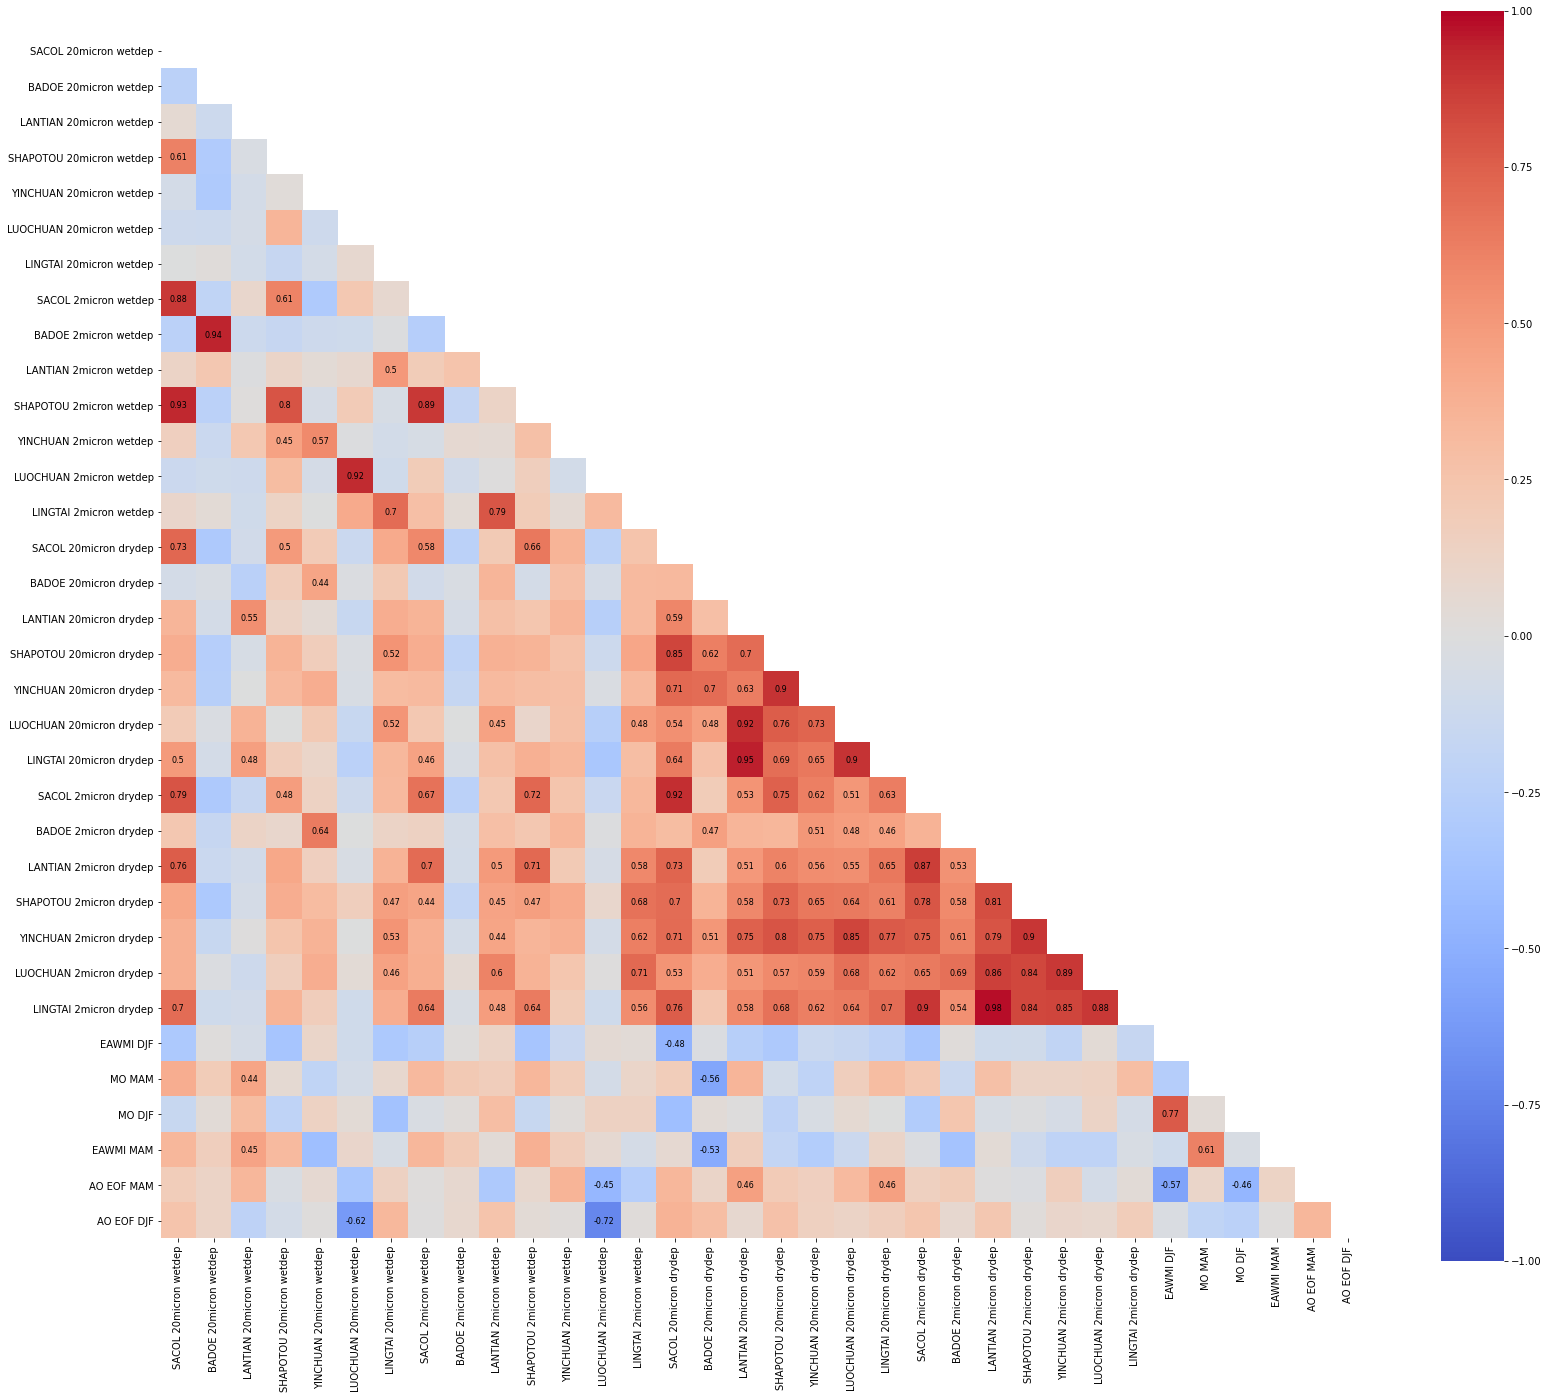

In [19]:
plot_correlations(source_contrib_ratio.apply(detrend_func,raw=True))